In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull

In [2]:
gene_name = 'MBP'

from velocity_util import find_best_pdb, read_pdb

pseudo_time = [str(i) for i in range(1, 10)]
pseudo_time_3D = dict()

for _dir in pseudo_time:
    _pdb_path = find_best_pdb('./{}_Mb/{}'.format(gene_name, _dir))
    pseudo_time_3D[_dir] = read_pdb(_pdb_path)[50:100]

pseudo_time_3D

{'1': array([[-6.836, -2.776,  0.031],
        [-2.796,  0.701,  2.051],
        [-5.143,  0.554,  3.017],
        [-5.461,  2.32 ,  2.723],
        [-6.845,  0.498,  1.486],
        [-4.382,  1.416,  4.451],
        [-6.088,  1.249,  4.634],
        [-7.318,  1.769, -1.616],
        [-5.162,  4.749, -1.003],
        [-5.114, -1.872, -0.992],
        [-5.011, -4.722,  0.363],
        [-3.055, -1.461,  3.647],
        [-5.746, -2.021,  3.099],
        [-2.079, -4.789, -3.357],
        [ 0.512, -3.947, -5.021],
        [-5.394, -4.044, -1.452],
        [-3.436, -6.499, -2.18 ],
        [-1.879, -5.045,  2.623],
        [-3.787, -3.765, -5.911],
        [ 1.798, -3.888, -2.189],
        [-0.538, -6.25 ,  1.034],
        [ 3.893, -5.761,  0.189],
        [-2.196, -7.147,  0.461],
        [ 6.247,  0.511,  2.434],
        [-3.977, -1.624, -4.412],
        [-3.287, -1.481, -5.835],
        [ 0.224, -0.763, -7.003],
        [-1.436,  4.24 , -5.227],
        [-1.354,  3.688, -6.78 ],
        [

In [3]:
def rotate(points1, points2):
    if (points1 == points2).all():
        return points1
    # 求解协方差矩阵C
    centroid1 = np.mean(points1, axis=0)
    centroid2 = np.mean(points2, axis=0)
    demeaned1 = points1 - centroid1
    demeaned2 = points2 - centroid2
    C = np.dot(demeaned1.T, demeaned2)

    # 使用SVD分解C得到旋转矩阵R
    U, S, Vt = np.linalg.svd(C)
    R = np.dot(U, Vt)
    
    points_rotated = np.dot(points2, R)
    return points_rotated

for i in pseudo_time:
    pseudo_time_3D[i] = rotate(pseudo_time_3D[pseudo_time[0]], pseudo_time_3D[i])

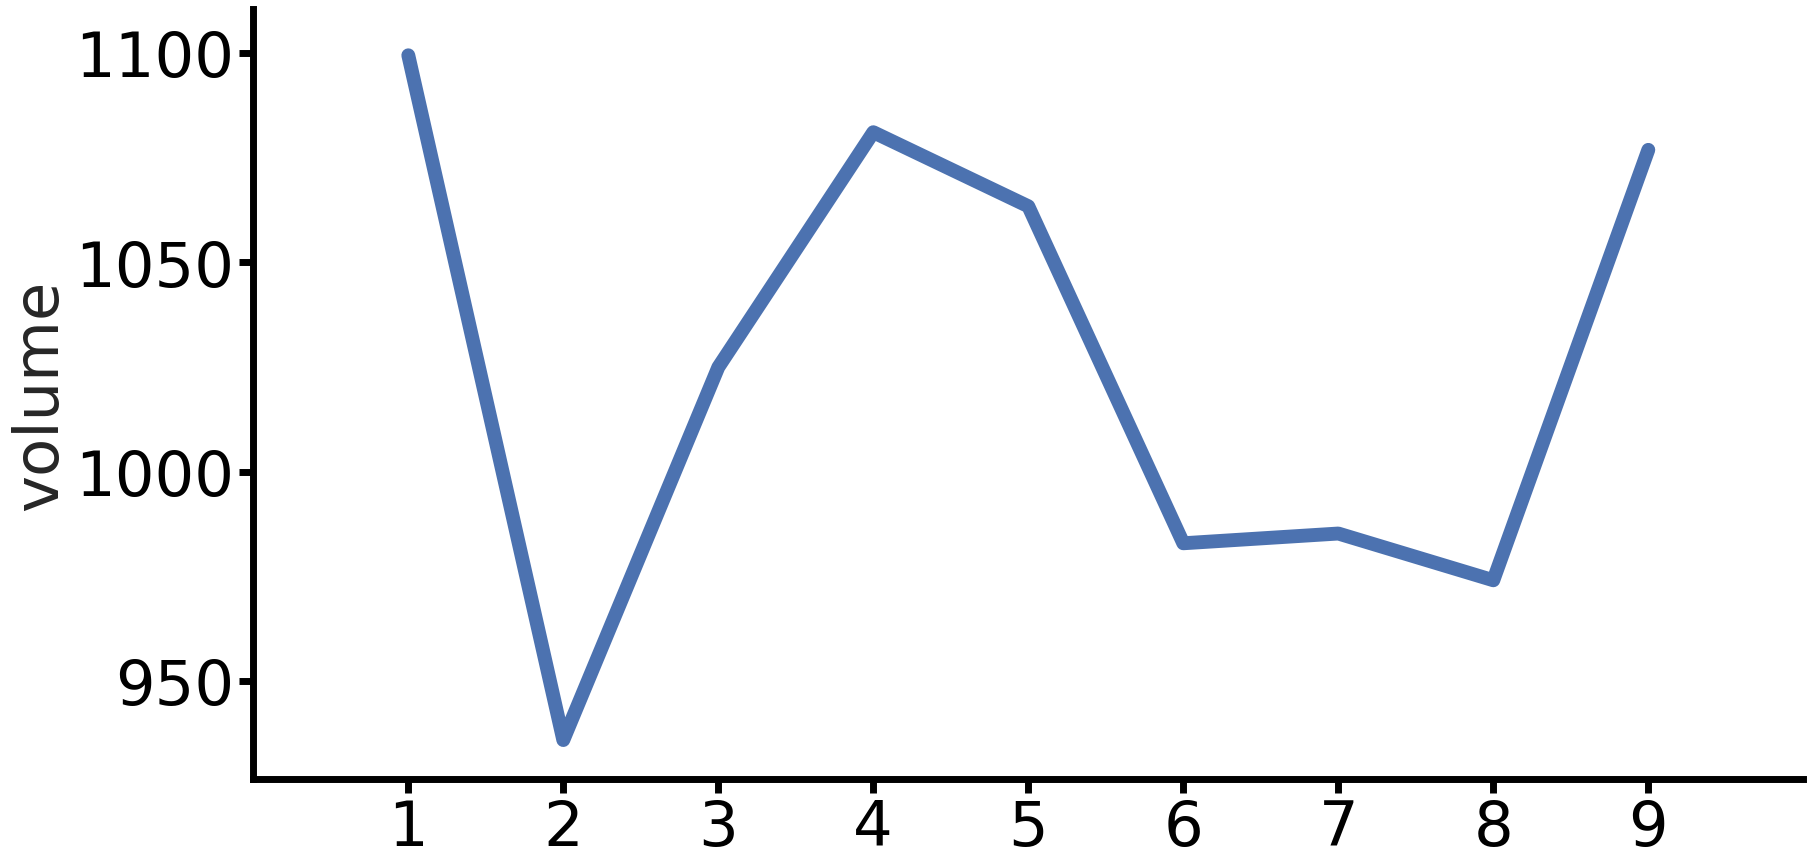

In [4]:
def calculate_volume(points):
    return ConvexHull(points).volume
volumes = [calculate_volume(pseudo_time_3D[i]) for i in pseudo_time]


import sys
sys.path.append('/lmh_data/work/SEE/analyse/')
from analyse_util import draw_pseudotime_line

draw_pseudotime_line(volumes, ylabel='volume',
#                      save_dir_path='/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}_Mb/volume'.format(gene_name)
                    )

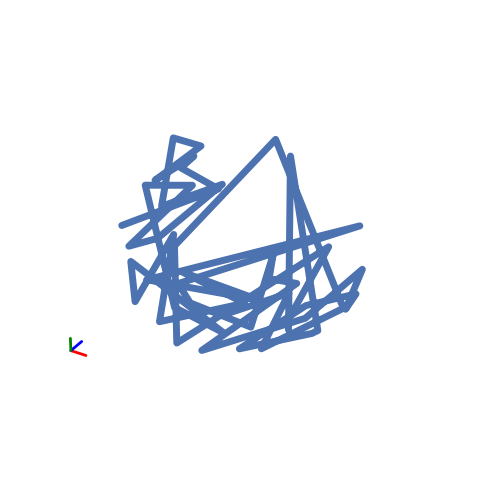

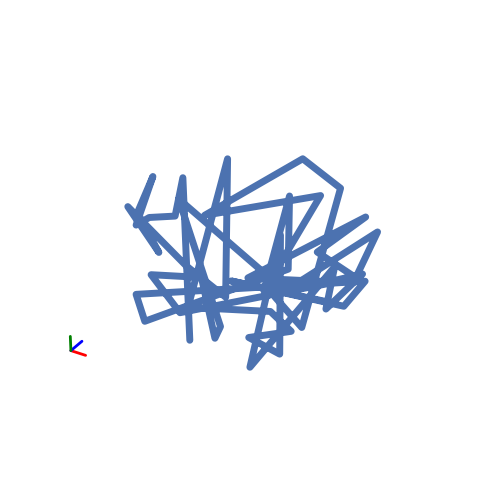

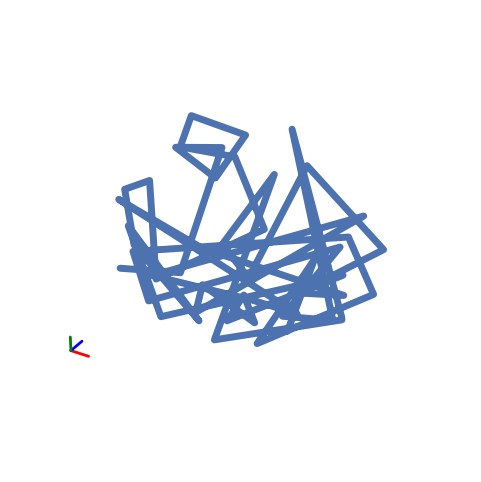

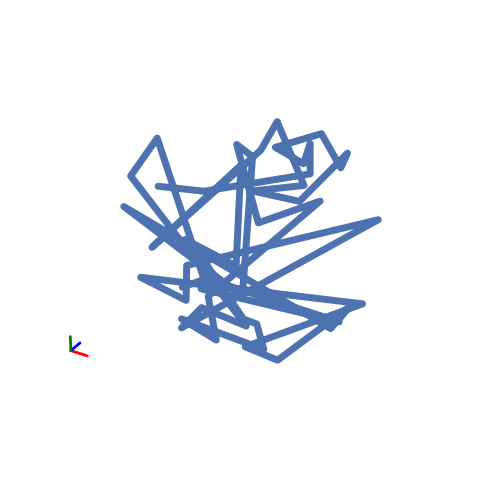

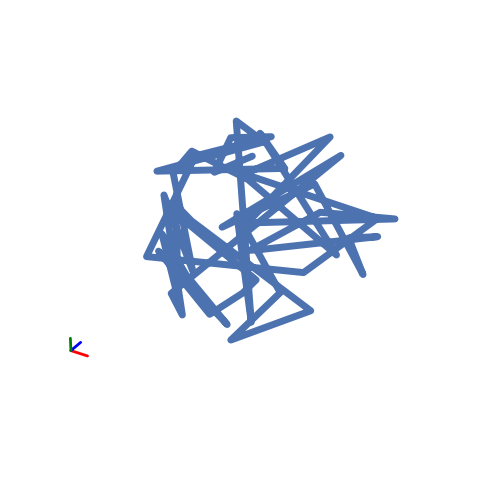

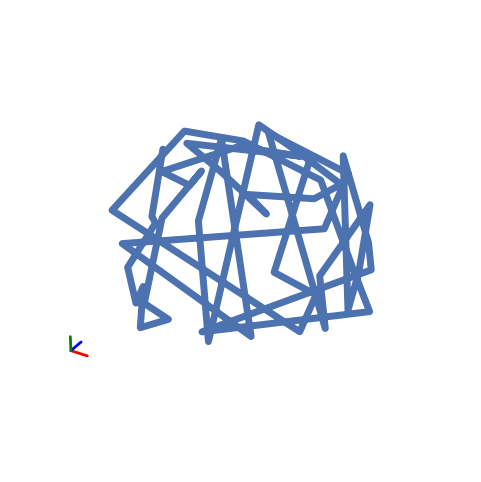

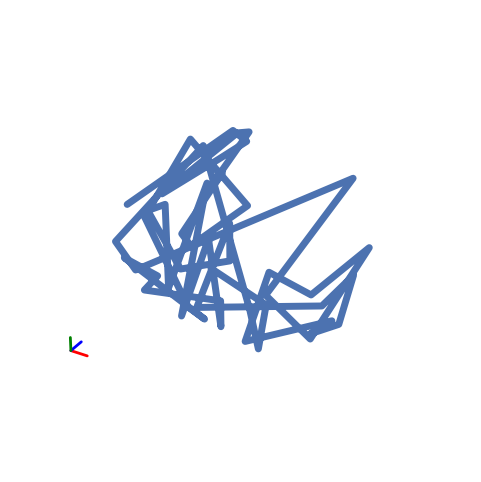

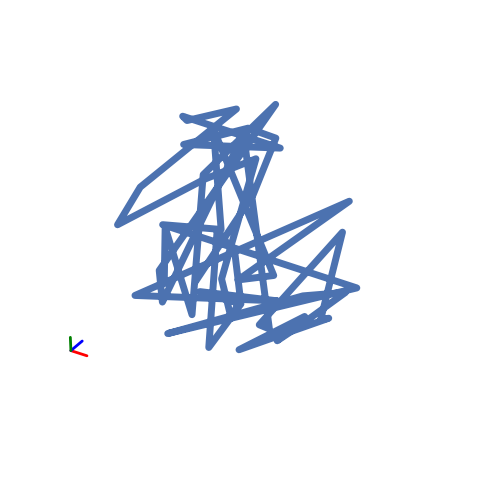

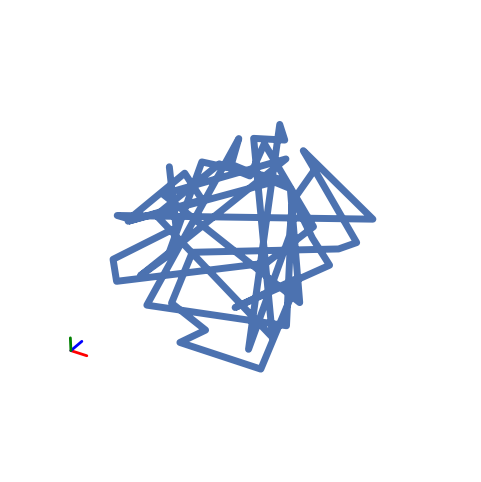

In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

def show(points, scores=None, maxval=1.0, title=None):
    very_large = 24; large = 22; med = 16; small = 12
    params = {'axes.titlesize': very_large,
              'legend.fontsize': med,
              'figure.figsize': (6, 6),
              'axes.labelsize': large,
              'axes.titlesize': large,
              'xtick.labelsize': large,
              'ytick.labelsize': large,
              'figure.titlesize': very_large,
              'lines.linewidth': 2}
    plt.rcParams.update(params)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.plot(points[:, 0], points[:, 1], points[:, 2], '-', linewidth=5)
    if scores is not None:
        scatter = ax.scatter(
            points[:, 0], points[:, 1], points[:, 2],
            c=scores, cmap=truncate_colormap(plt.get_cmap("Reds"), 0, maxval), s=very_large*10
        )

    origin = [min(points[:, 0]), min(points[:, 1]), min(points[:, 2])]
    ax.plot([origin[0], origin[0]+1], [origin[1], origin[1]], [origin[2], origin[2]], '-', color='red')
    ax.plot([origin[0], origin[0]], [origin[1], origin[1]+1], [origin[2], origin[2]], '-', color='blue')
    ax.plot([origin[0], origin[0]], [origin[1], origin[1]], [origin[2], origin[2]+1], '-', color='green')
    
    if scores is not None:
        fig.colorbar(scatter, ax=ax, fraction=0.02)
    ax.grid(False)
    ax.axis("off")

    if title != None:
        plt.title('{}'.format(title))
        plt.savefig('/lmh_data/work/SEE/analyse/figure_file/pseudo_time/{}_Mb/3D/{}.pdf'.format(gene_name, title),
                    format='pdf', bbox_inches='tight')
    plt.show()
    
for i in pseudo_time:
    show(pseudo_time_3D[str(i)])

In [6]:
counts = np.load('./temp/{}.npy'.format(gene_name), allow_pickle=True).item()['expression_counts']
counts = [count.item() for count in counts]
vmax = max(counts)
vmax

20.95652198791504

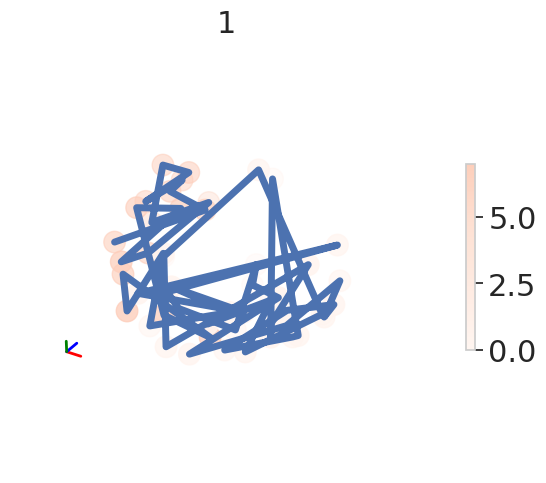

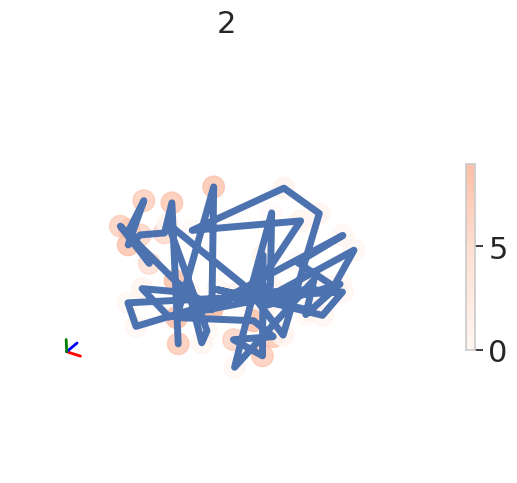

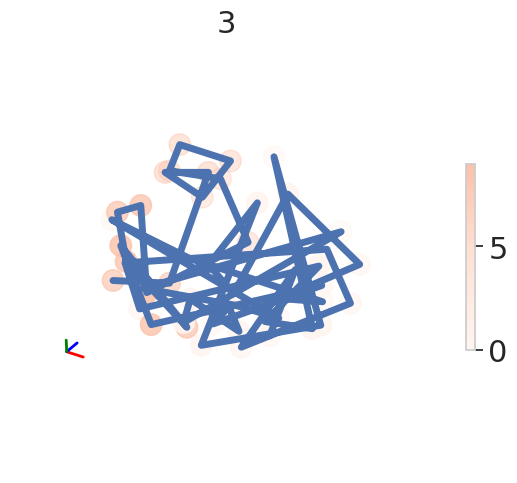

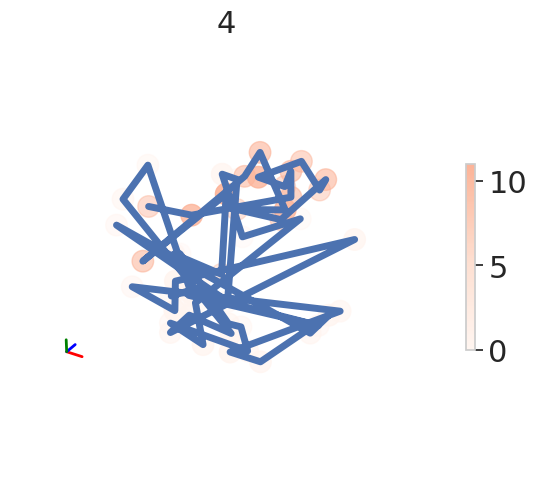

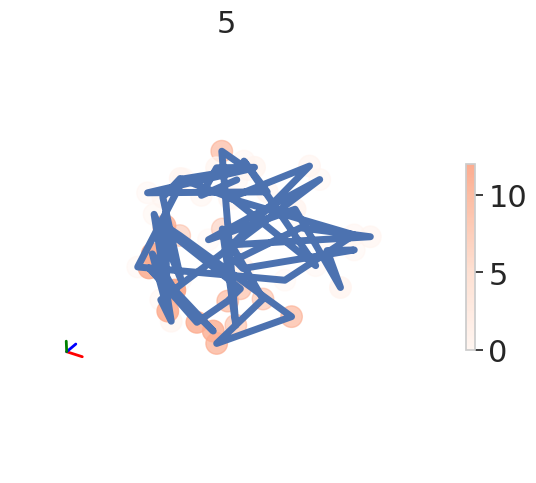

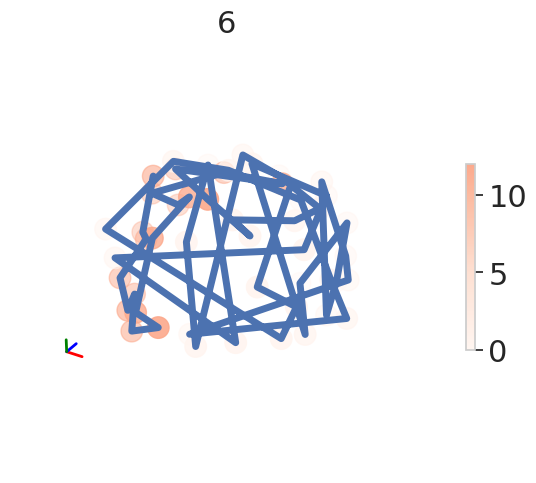

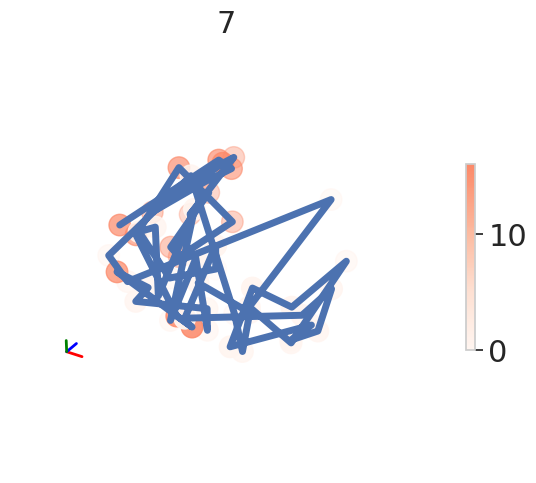

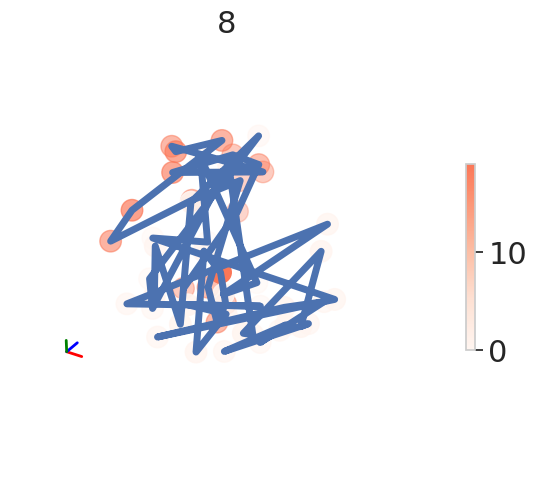

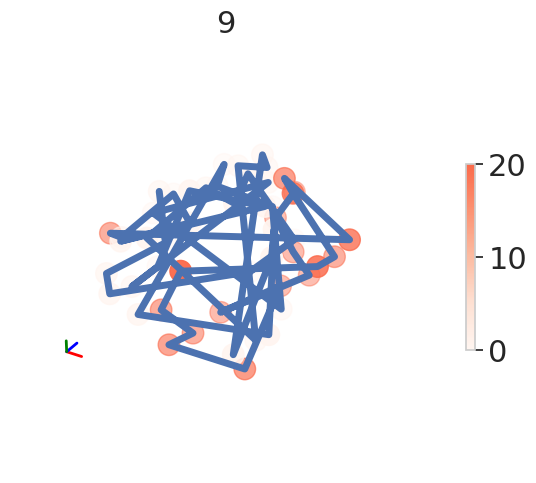

In [7]:
scores = np.array([0] * 50)
for i in range(1, 10):
    scores[:17] = counts[i-1]
    show(pseudo_time_3D[str(i)], scores, counts[i-1]/(vmax*2), title=i)